### Statistical inference


In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
#from scipy.integrate import odeint
import mplcyberpunk
import tqdm
#from functions import nth_derivative
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize

In [6]:
#plt.style.use('cyberpunk')

In [7]:
cov=np.loadtxt('cov_mu.txt', skiprows=0)

In [8]:
cov.shape

(31, 31)

In [9]:
#cov=cov.reshape((31,31))

In [10]:
# shoes=pd.read_csv('pantheon+_lcparam_full_long_zhel.txt')
shoes=np.loadtxt('datos_mu.txt')
shoes.shape

(31, 2)

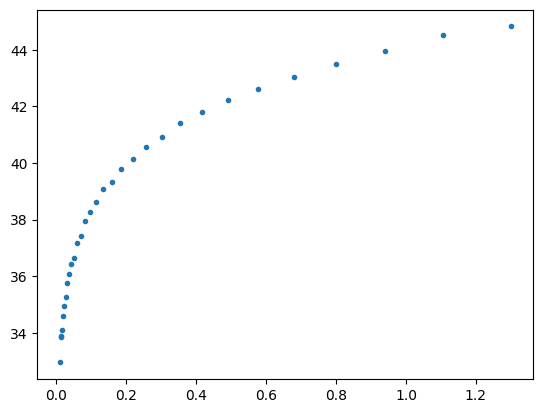

In [11]:
redshift=shoes[:,0].reshape(-1,1)
mu=shoes[:,1].reshape(-1,1)

plt.plot(redshift, mu, '.')

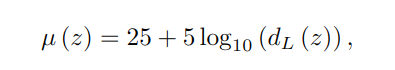

In [12]:
#importing model
nodos=20
ANN =  nn.Sequential(nn.Linear(3, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos)
                    nn.Tanh(),nn.Linear(nodos,1))

ANN.load_state_dict(torch.load('CPL_param_dict_50'))
ANN.eval()

Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=1, bias=True)
)

In [13]:
#The reparametrization of the neuralnetwork 7
zi=0.0
def Param(T,net=ANN,ti=zi):
    out = net(T)
    b=1-torch.exp(ti-T[:,0].view(-1,1))
    return 0.0 + b.view(-1,1)*out

In [14]:
#the dL distance from the neural network
z = torch.tensor(redshift, dtype=float)

def ANN_dL(omegas):
    T = torch.cat((z, omegas[0] * torch.ones_like(z), omegas[1] * torch.ones_like(z)), 1)
    T = T.to(torch.float)
    return 1/67.0*(1+z)*Param(T).detach()
    

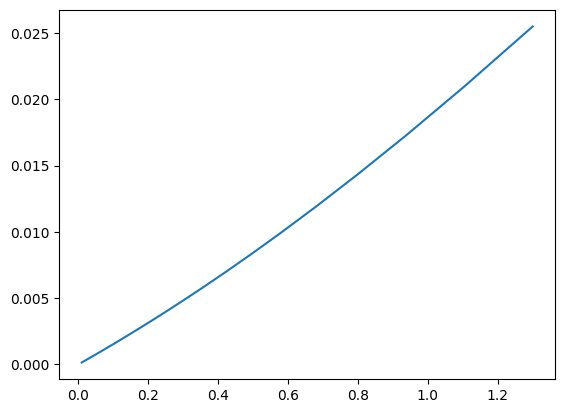

In [15]:
plt.plot(redshift,ANN_dL([0,-1]))

In [16]:
#Y ahora la DL numérica
Omega_m0 = 0.3
Omega_Lambda0 = 0.7
#omega_0, omega_a = 1,1

zi=0.0
#zf=3.0

def integrand(z1, omega_0, omega_a):
    return 1 / np.sqrt(Omega_m0 * (1 + z1)**3 + Omega_Lambda0 * (1 + z1)**(3 * (1 + omega_0 + omega_a)) * np.exp(-3 * omega_a * z1 / (1 + z1)))

def DL(omegas):
    dis=np.zeros_like(redshift)
    for i,z0 in enumerate(redshift):
        dis[i],_=quad(integrand, zi, z0,args=(omegas[0], omegas[1]))
    return 1/67.0*(1+redshift)*dis  


map_0=1
map_a=1

def DL_map(z):
    #dis=np.zeros_like(redshift)
    dis,_ = quad(integrand, zi, z,args=(map_0, map_a))
    return 1/67.0*(1+z)*dis 

In [17]:
%%timeit 
map_0=1
map_a=1
np.array(list(map(DL_map, redshift)))

2.95 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit 
DL([1,1])


2.85 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit
ANN_dL([1,1])

375 µs ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


La versión del ciclo for es más práctica para evaluar distintas combinaciones de parámetros w_0, w_a.

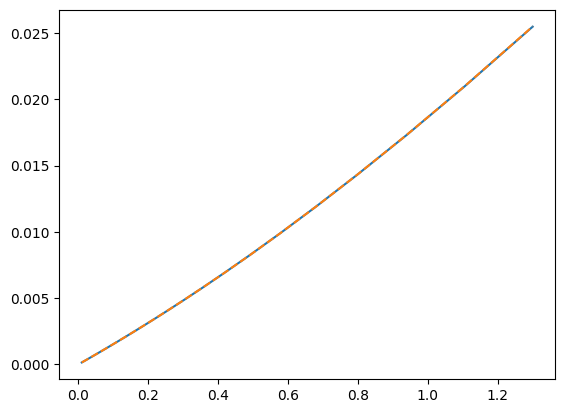

In [20]:
plt.plot(redshift, DL([0,-1]))
plt.plot(redshift, ANN_dL([0,-1]),'--')

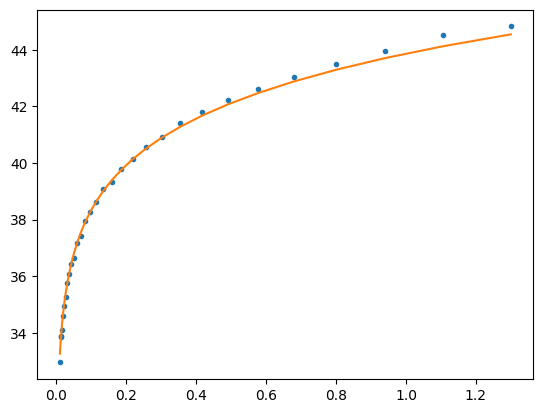

In [21]:
#Ahora veamos si es capaz de ajsutar el módulo de distancia, tanto el numérico como la red
plt.plot(redshift,mu,'.')
plt.plot(redshift, 25+5*np.log10(3e5*ANN_dL([-3.444e-01 ,-1.789e-01])))
#plt.plot(redshift, 25+5*np.log10(3e5*ANN_dL([1,-1.0])))

Existen basicamente dos maneras de evaluar el likelihood utilizando la red neuronal, el primero es evaluar punto por punto sobre z, para una misma combinación de parámetros libres.

El otro, es completar un arreglo con todos los z y los respectivos parámetros y evlauarlos en una sola propagación hacia delante.

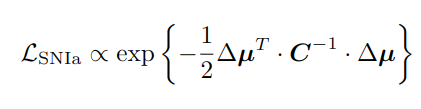

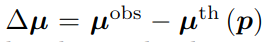

In [22]:
%%timeit 
MU = 25+5*np.log10(3e5*DL([1,1]))
d_mu = mu-MU
#type(d_mu[0,0])
np.dot(np.linalg.inv(cov),d_mu)
#np.dot(np.linalg.inv(cov),d_mu)
#np.dot(d_mu.T, np.dot(np.linalg.inv(cov),d_mu))

4.58 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
mutensor=torch.tensor(mu)
covtensor=torch.tensor(cov)

In [24]:
%%timeit 
MU=25+5*np.log10(3e5*ANN_dL([1,1]))
d_mu = mutensor-MU
#type(d_mu[0,0])
torch.matmul(d_mu.T,torch.matmul(torch.linalg.inv(covtensor),d_mu)).numpy()

#np.dot(d_mu.T, np.dot(np.linalg.inv(cov),d_mu))

586 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [32]:
omega0, omegaa = 1,1

In [33]:
%timeit 25+5*np.log10(3e5*DL([omega0, omegaa]))

2.94 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
def L_ANN(omegas):
    MU=25+5*np.log10(3e5*ANN_dL(omegas))
    d_mu = mutensor-MU
    exp = torch.matmul(d_mu.T,torch.matmul(torch.linalg.inv(covtensor),d_mu)).numpy()
    return 0.5*exp 

In [35]:
# def L_ANN(omegas):
#     MU=25+5*np.log10(3e5*ANN_dL(omegas))
#     d_mu = mu-MU.numpy()
#     #exp = np.dot(d_mu.T, np.dot(np.linalg.inv(cov),d_mu))
#     return np.sum(d_mu**2)/np.var(mu)

In [36]:
# bnds = ((-3, 3), (-3, 3))
# minimize(L_ANN,[0.5,0.5], bounds=bnds)

In [37]:
L_ANN([5,5])

array([[5554.0074772]])

In [38]:
#hacemos la inferencia
from scipy.stats import multivariate_normal
from scipy.stats import chi2

def metropolis_hastings(L_ANN, omega0, omegaa, steps, sigma):
  # Inicializar variables
  omega_actual = np.array([omega0, omegaa])
  mejores_omegas = []
  
  for _ in range(steps):
    # Proponer un nuevo estado
    omega_propuesto = omega_actual + np.random.normal(0, sigma, 2)
    
    # Calcular la razón de aceptación
    ratio = L_ANN(omega_propuesto) / L_ANN(omega_actual)
    
    # Aceptar o rechazar el nuevo estado
    if ratio <= 1:
      omega_actual = omega_propuesto
    else:
      u = np.random.uniform(0, 1)
      if u > ratio:
        omega_actual = omega_propuesto
    
    # Almacenar el mejor estado
    mejores_omegas.append(omega_actual.copy())
  
  return mejores_omegas

In [39]:
def graficar_regiones_confianza(mejores_omegas):
  # Calcular la matriz de covarianza
  cov = np.cov(np.array(mejores_omegas).T)
  
  # Generar puntos para la elipse de confianza
  puntos_elipse = []
  for theta in np.linspace(0, 2*np.pi, 100):
    punto = np.array([0, 0]) + 2 * np.sqrt(chi2(0.95, 2)) * np.dot(np.linalg.eig(cov)[1], np.array([np.cos(theta), np.sin(theta)]))
    puntos_elipse.append(punto)
  
  # Graficar
  plt.scatter([omega[0] for omega in mejores_omegas], [omega[1] for omega in mejores_omegas], c='b', alpha=0.5)
  plt.plot([punto[0] for punto in puntos_elipse], [punto[1] for punto in puntos_elipse], c='r')
  plt.xlabel('omega0')
  plt.ylabel('omegaa')
  plt.show()


In [40]:
# Parámetros
omega0 = 0
omegaa = 0
steps = 1000
sigma = 0.1

# Ejecutar Metropolis-Hastings


# Graficar regiones de confianza
#graficar_regiones_confianza(mejores_omegas)


In [41]:
#tiempo de la red
%timeit mejores_omegas = metropolis_hastings(L_ANN, omega0, omegaa, steps, sigma)

1.33 s ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
mejores_omegas = metropolis_hastings(L_ANN, omega0, omegaa, steps, sigma)

In [43]:
np.array(mejores_omegas)[-1]

array([-0.51620316, -2.08121181])

In [44]:
L_ANN(np.array(mejores_omegas)[-1])

array([[20.96691199]])

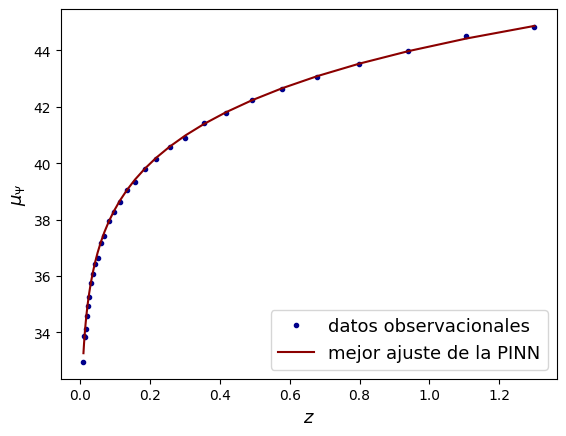

In [64]:
#Ahora veamos si es capaz de ajsutar el módulo de distancia, tanto el numérico como la red
plt.plot(redshift,mu,'.', color='darkblue', label='datos observacionales')
plt.plot(redshift, 25+5*np.log10(3e5*ANN_dL(mejores_omegas[-1])), color='darkred', label='mejor ajuste de la PINN')
plt.legend(fontsize=13)
plt.xlabel('$z$', size=13)
plt.ylabel('$\mu_{\mathcal{\Psi}}$', size = 13)
plt.savefig('ajuste_mu_pinn.pdf')


In [46]:
# Ahora la inferencia con el método numérico
def L_DL(omegas):
    MU=25+5*np.log10(3e5*DL(omegas))
    d_mu = mu-MU
    exp = np.dot(d_mu.T, np.dot(np.linalg.inv(cov),d_mu))
    return 0.59*exp

In [48]:
%timeit omegas_DL = metropolis_hastings(L_DL, omega0, omegaa, steps, sigma) 

11 s ± 173 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
omegas_DL = metropolis_hastings(L_DL, omega0, omegaa, steps, sigma) 

In [50]:
L_DL(np.array(omegas_DL)[-1])

array([[25.10242513]])

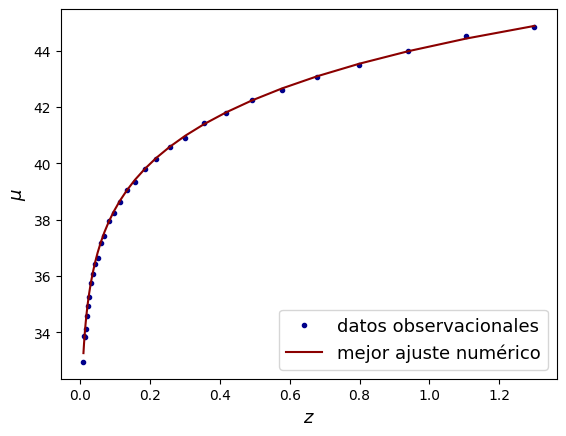

In [65]:
plt.plot(redshift,mu,'.', color='darkblue', label='datos observacionales')
plt.plot(redshift, 25+5*np.log10(3e5*DL(omegas_DL[-1])), color='darkred', label='mejor ajuste numérico')
plt.xlabel('$z$', size=13)
plt.ylabel('$\mu$', size = 13)
plt.legend(fontsize=13)
plt.savefig('ajuste_mu_numeric.pdf')

In [66]:
# def f(x, y):
#     return np.sin(np.sqrt(x ** 2 + y ** 2))

o0 = np.linspace(-2.5, 2.5, 50)
oa = np.linspace(-2.5, 2.5, 50)

O0, Oa = np.meshgrid(o0, oa)
#Z = f(X, Y)
imag=np.ones_like(O0)

for i,x in enumerate(o0):
    for j,y in enumerate(oa):
        imag[i,j]=L_ANN([x,y])
        #print([x,y])
        


/tmp/ipykernel_55595/857560447.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  imag[i,j]=L_ANN([x,y])


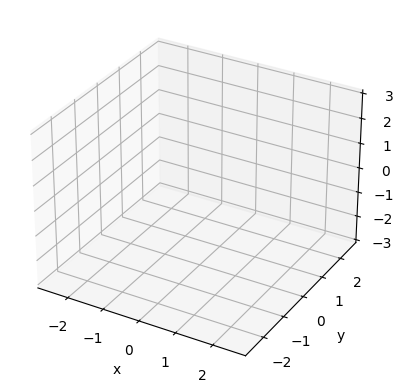

In [67]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(O0, Oa, imag, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(-3, 3);

In [75]:
def graficar_segmentos(A, titulo:str):
  """
  Grafica los segmentos de línea que unen los puntos en el array A.

  Args:
    A: Un array de vectores, donde cada vector tiene dos elementos.

  Returns:
    None.
  """

  # Obtener las coordenadas de los puntos
  x = A[:, 0]
  y = A[:, 1]
  
  
  # Graficar los segmentos de línea
  for i in range(len(A) - 1):
    plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], 'o-', label=titulo, color='darkcyan')
    
  
  
  # Mostrar la gráfica
  plt.title(titulo)
  mplcyberpunk.make_lines_glow();
  plt.savefig('metro_pinn.png')
  plt.grid()
  plt.show()
  plt.legend()
  


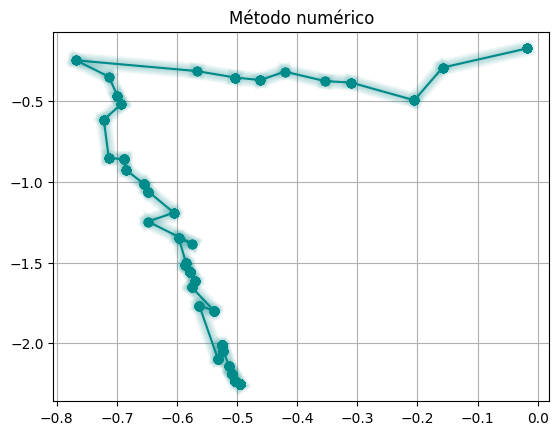

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


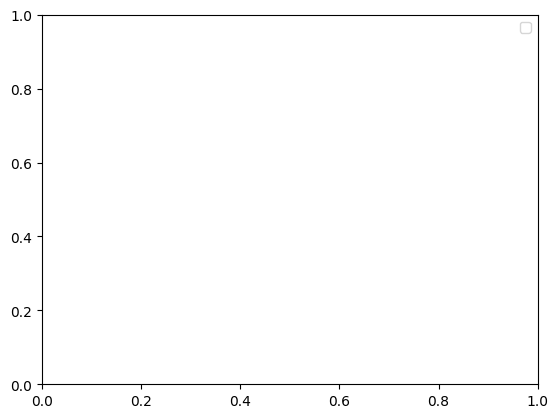

In [74]:
graficar_segmentos(np.array(omegas_DL), 'Método numérico')
#plt.savefig('metro_numeric.png')

In [56]:
np.array(omegas_DL)[-1]

array([-0.50425697, -2.23121651])

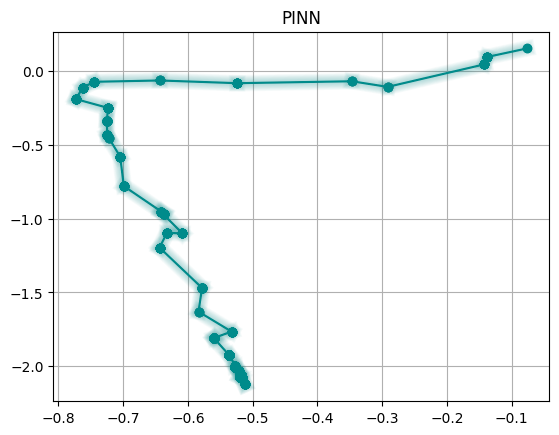

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


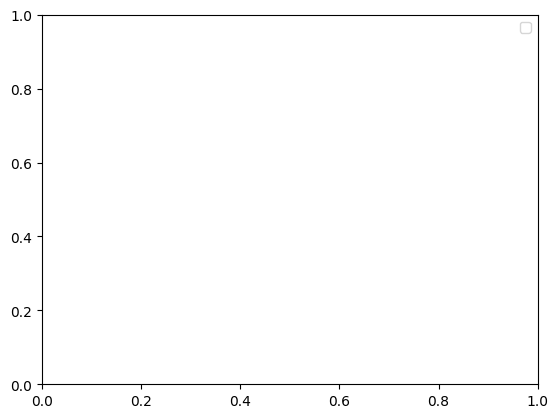

In [76]:
graficar_segmentos(np.array(mejores_omegas), 'PINN')
